# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torch
from torch import nn, optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
data_dir_train = '/data/landmark_images/train'
data_dir_test = '/data/landmark_images/test'

# number of subprocesses to use for data loading
num_workers = 2
# percentage of training set to use as validation
valid_size = 0.2

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(20),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224)),
                                       transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir_train, transform = train_transforms)
# valid_data = datasets.ImageFolder(data_dir_train, transform = train_transforms)
test_data = datasets.ImageFolder(data_dir_test, transform = test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle= True)
validloader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=num_workers)

len_trainloader =  len(trainloader)
len_validloader = len(validloader)

loaders_scratch = {'train': trainloader, 'valid': validloader, 'test': testloader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- How does your code resize the images (by cropping, stretching, etc)?  

We are resizing the images to 224 by 224, center croping them, flipping and rotating them horizontaly randomly.

- What size did you pick for the input tensor, and why?
When we perform transfer learning, which is one of the final steps of this project, we have to shape our input data into the shape that pretrained model will expect. So we will need to transform our data to what it is expected. Since we will be doing transfer learning using VGG-16, we know that this takes 224x224 images as input, hence we need to resize all of them.


- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

We know that the images can have some level of invariance, such as scale or translation. CNN have some variaves that we can use for our model. We are using rotation and flips to add some more perception of variation to pur model.


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [11]:
def imshow(image, ax=None, normalize=False):
    """Imshow for Tensor."""   
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

42.Death_Valley_National_Park
14.Terminal_Tower
40.Stockholm_City_Hall
39.Gateway_of_India
42.Death_Valley_National_Park


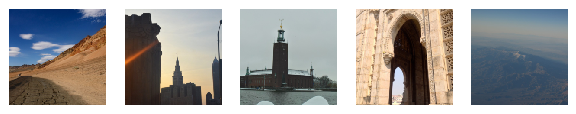

In [12]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir_train, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

images, labels = next(iter(dataloader))
# get name of the classes -- 50 classes
class_names = dataset.classes

fig, axes = plt.subplots(figsize=(10,4), ncols=5)

for ii in range(5):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)
    # get name of the class
    print(dataset.classes[labels[ii].item()])


### Initialize use_cuda variable

In [13]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(torch.cuda.is_available())

True


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [14]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.02)
    return optimizer    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [22]:
import torch.nn as nn
from torch import nn, optim
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()        
        # define convolutional layers
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # 3 x 224 x 224
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 16 x 112 x 112
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 32 x 56 x 56
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.dropout = nn.Dropout(0.20)
        
        # define a pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        hidden_1 = 500
        ## Define layers of a CNN
        self.fc1 = nn.Linear(64 * 28 * 28, hidden_1)
        # we have 50 classes, so we need 50 output nodes
        self.fc2 = nn.Linear(hidden_1, 50)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.20)

        
    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Define forward behavior
        # make sure input tensor is flattened
        x = x.view(-1, 64 * 28 * 28) 
        x = self.dropout(x)        
        x = F.relu(self.fc1(x))        
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
#         x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
# print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

A CNN first take an input image then put that image through several convolutional and pooling layers. This results in a set of feature maps reduced in size from the original image. We then need to flatten these maps creating a feature vector that we can then pass to a series of fully connected linear layers. These will result in a probability distribution for the classes.

With this we can now extract the predicted class for the input image, an image is placed as an input and a predicted class labes will the the output.

Steps:

- define batch size which is the number of training images that will be see in one training iteration.
- transform training and test data into a tensor datatype.
- create training a test loaders which are responsible for giving us a way to iterate though the data one batch at a time.
- visualize the data to make sure the images look as we expect them.
- define convolutional layers specifying its parameters: Depth of the input and output, size if the filters, stride left as default and padding = 1 because it misses the norder pixels by one.
- apply relu activation function to scale the output of a previous layer to be consistent small value.
- define pooling layer with filter size 2 and strideof 2, to make the x and y dimensions half of what they were from the previous layer.
- connect the output to a fully connected layer.


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [23]:
# create lists to visualize training and validation loss
train_losses, test_losses = [], []

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
       
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            ## TODO: find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
                   
            loss.backward()
            optimizer.step()
                    
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            batch_loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (batch_loss.data.item() - valid_loss))
        
        # model.train()        
        #append to list to graph results
        train_losses.append(loss/len_trainloader)
        test_losses.append(batch_loss/len_validloader)
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(loaders['train'].dataset)
        valid_loss = valid_loss / len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model..'.format(
            valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
               
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [24]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Conv2d') != -1:
        # get the number of the inputs
        n = m.in_channels
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
model_scratch.apply(weights_init_uniform_rule)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000840 	Validation Loss: 0.000790
Validation loss decreased (inf --> 0.000790).  Saving model..
Epoch: 2 	Training Loss: 0.000743 	Validation Loss: 0.000709
Validation loss decreased (0.000790 --> 0.000709).  Saving model..
Epoch: 3 	Training Loss: 0.000695 	Validation Loss: 0.000656
Validation loss decreased (0.000709 --> 0.000656).  Saving model..
Epoch: 4 	Training Loss: 0.000645 	Validation Loss: 0.000682
Epoch: 5 	Training Loss: 0.000607 	Validation Loss: 0.000610
Validation loss decreased (0.000656 --> 0.000610).  Saving model..
Epoch: 6 	Training Loss: 0.000577 	Validation Loss: 0.000597
Validation loss decreased (0.000610 --> 0.000597).  Saving model..
Epoch: 7 	Training Loss: 0.000546 	Validation Loss: 0.000500
Validation loss decreased (0.000597 --> 0.000500).  Saving model..
Epoch: 8 	Training Loss: 0.000521 	Validation Loss: 0.000472
Validation loss decreased (0.000500 --> 0.000472).  Saving model..
Epoch: 9 	Training Loss: 0.000491 	Validation Lo

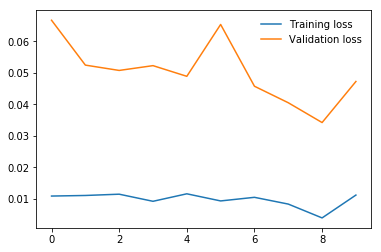

In [25]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [26]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [27]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [25]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.989947


Test Accuracy: 25% (320/1250)


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [28]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 40

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000778 	Validation Loss: 0.000762
Validation loss decreased (inf --> 0.000762).  Saving model..
Epoch: 2 	Training Loss: 0.000752 	Validation Loss: 0.000761
Validation loss decreased (0.000762 --> 0.000761).  Saving model..
Epoch: 3 	Training Loss: 0.000715 	Validation Loss: 0.000698
Validation loss decreased (0.000761 --> 0.000698).  Saving model..
Epoch: 4 	Training Loss: 0.000686 	Validation Loss: 0.000689
Validation loss decreased (0.000698 --> 0.000689).  Saving model..
Epoch: 5 	Training Loss: 0.000658 	Validation Loss: 0.000707
Epoch: 6 	Training Loss: 0.000628 	Validation Loss: 0.000606
Validation loss decreased (0.000689 --> 0.000606).  Saving model..
Epoch: 7 	Training Loss: 0.000597 	Validation Loss: 0.000580
Validation loss decreased (0.000606 --> 0.000580).  Saving model..
Epoch: 8 	Training Loss: 0.000571 	Validation Loss: 0.000590
Epoch: 9 	Training Loss: 0.000549 	Validation Loss: 0.000552
Validation loss decreased (0.000580 --> 0.000552).  Sa

In [29]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

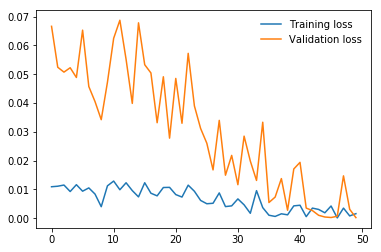

In [30]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [31]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.147892


Test Accuracy: 36% (456/1250)


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [32]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [33]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.02)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [34]:
## TODO: Specify model architecture
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 50 classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(class_names), bias=True)
model_transfer.classifier[6] = last_layer

print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 110485982.35it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

In this case we were supposed to use a pre-trained network. In the first part of this project we defined our own network, now we are going to use a method that is called transfer learning, which is a method in which we can use an already trained model that has been used for another task. Since this model has been already trained the time and resources already used can save us a lot of time and often will give us great results.

The first step will be te create a new model using vgg16, which loads a set of weights pre-trained on ImageNet.

model_transfer = models.vgg16(pretrained=True)

The second step is to freeze  the training for all features layers.

Add last linear layer which is the number of inputs and specify the output layer which are 50 classes.

Replace the final fully connected layuer with our own classifier. This way we will be able to use vgg as a fixed feature extractor for our images then easily train a simple calssifier on toip of that.


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [35]:
model_transfer = train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.000433 	Validation Loss: 0.000261
Validation loss decreased (inf --> 0.000261).  Saving model..
Epoch: 2 	Training Loss: 0.000283 	Validation Loss: 0.000209
Validation loss decreased (0.000261 --> 0.000209).  Saving model..
Epoch: 3 	Training Loss: 0.000241 	Validation Loss: 0.000171
Validation loss decreased (0.000209 --> 0.000171).  Saving model..
Epoch: 4 	Training Loss: 0.000204 	Validation Loss: 0.000141
Validation loss decreased (0.000171 --> 0.000141).  Saving model..
Epoch: 5 	Training Loss: 0.000180 	Validation Loss: 0.000139
Validation loss decreased (0.000141 --> 0.000139).  Saving model..
Epoch: 6 	Training Loss: 0.000160 	Validation Loss: 0.000119
Validation loss decreased (0.000139 --> 0.000119).  Saving model..
Epoch: 7 	Training Loss: 0.000145 	Validation Loss: 0.000088
Validation loss decreased (0.000119 --> 0.000088).  Saving model..
Epoch: 8 	Training Loss: 0.000124 	Validation Loss: 0.000074
Validation loss decreased (0.000088 --> 0.000074

In [36]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [37]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.015065


Test Accuracy: 76% (961/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [39]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    count = 0
    images, labels = next(iter(trainloader))
    
    # move model inputs to cuda, if GPU available
    if use_cuda:
        images = images.cuda()

    # get sample outputs
    output = model_transfer(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = set((np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())).flatten())
    
    for i in preds:
        count += 1
        x = dataset.classes[i]
        s = x.split('_')
        j = ' '
        name = j.join(s)
        print(name[3:])
        if(count == k):
            break;

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)



Mount Rainier National Park
Ljubljana Castle
Monumento a la Revolucion
Dead Sea
Grand Canyon


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the:
Great Barrier Reef
London Olympic Stadium
Atomium


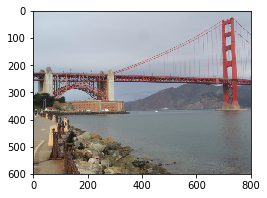

In [44]:
import re
def suggest_locations(img_path):
    print("Is this picture of the:")
      
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    #read the image
    im = Image.open(img_path)
    fig = plt.figure(figsize=(12,3))
    plt.imshow(im)
    plt.show()

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output it is better than I expected considering that it only has an accuracy of 74%. Many times when suggest_locations function was ran, the locations suggested did match the given image.

Some possible points for improvement would be to increase the accuracy of the training.

I also noticed that playing with the values of learning rate makes a difference on the efficiency of the model. This option can also be explored with several variations of this value to find the one that it is the most efficient.

Increasing the number of epochs can also give a higher accuracy rate. The key is to find when the validation loss value stops decreasing. In general this is the time we want to stop training.

In this model I used only one hidden layer. I would consider adding a new one and would expect the model to be more effiecient, the only reason I only attempted one was due to time contstrains. But this would be absolutely something I would expect to produce and improvement for the model.

Is this picture of the:
Hanging Temple
Sydney Opera House
Great Barrier Reef


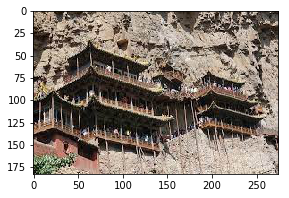

In [45]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('images/test/hangingtemple.jpeg')


images/test/download1.jpeg
Is this picture of the:
Hanging Temple
Haleakala National Park
Ljubljana Castle


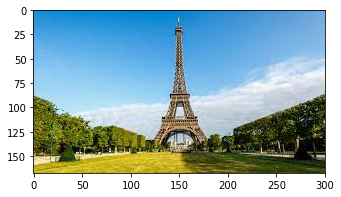

In [42]:
suggest_locations('images/test/download1.jpeg')


Is this picture of the:
Haleakala National Park
Badlands National Park
Atomium


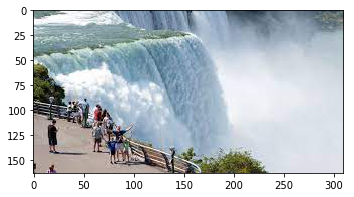

In [46]:

suggest_locations('images/test/download2.jpeg')

Is this picture of the:
Haleakala National Park
Ljubljana Castle
Monumento a la Revolucion


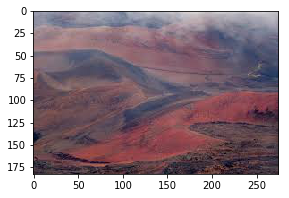

In [47]:
suggest_locations('images/test/halakealationalpark.jpeg')